In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("./ajt_dataset.csv")

In [3]:
df.head(10)

,text,true_text,around_text,description_mistake,source,is_mistake,type_mistake,students_degree
0,Создание новой версии Личного Кабинета МИ...,Создание новой версии Личного Кабинета МИ...,Создание новой версии Личного Кабинета МИ...,нарушение в построении предложения с причастны...,https://www.hse.ru/edu/vkr/922075150,1.0,грамматическая,бакалавриат
1,Новая версия Кабинета должна быть развёрнута н...,Новая версия Кабинета должна быть развёрнута н...,Требования к результатам работы Новая версия К...,пропушена запятая между частями сложносочинённ...,https://www.hse.ru/edu/vkr/922075150,1.0,пунктуационная,бакалавриат
2,Новая версия Кабинета должна быть развёрнута н...,Обновлённая версия Кабинета должна быть развер...,Требования к результатам работы Новая версия К...,тавтология,https://www.hse.ru/edu/vkr/922075150,1.0,речевая,бакалавриат
3,Кабинет доказал свою эффективность и необ...,"Несмотря на эффективность Кабинета, его дизайн...",В МИЭМ НИУ ВШЭ с 2018 года реализуется проектн...,"использование союза ""однако""",https://www.hse.ru/edu/vkr/922075150,1.0,стилистическая,бакалавриат
4,Устаревшая кодовая база не позволяет за приемл...,Устаревшая кодовая база не позволяет своевреме...,Кабинет доказал свою эффективность и необ...,"неопределённое понятие ""приемлемое время""",https://www.hse.ru/edu/vkr/922075150,1.0,стилистическая,бакалавриат
5,Целью данного проекта является написание с нул...,Целью проекта является создание новой версии К...,Текущий интерфейс не соответствует современным...,"использование слова ""данный"" в значении ""этот""...",https://www.hse.ru/edu/vkr/922075150,1.0,стилистическая,бакалавриат
6,При поиске эффективного метода обучения рассма...,При поиске эффективного метода обучения рассма...,При поиске эффективного метода обучения рассма...,"избыточность, неверный выбор паронима из пары ...",https://www.hse.ru/edu/vkr/922075150,1.0,лексическая,бакалавриат
7,Наряду с этим относительно новый подход в обра...,Наряду с этим в образовании во всём мире наби...,При поиске эффективного метода обучения рассма...,неыерный порядок слов в предложении,https://www.hse.ru/edu/vkr/922075150,1.0,грамматическая,бакалавриат
8,Проектная модель обучения ­- это педагогическ...,Проектная модель обучения ­ - это педагогическ...,При поиске эффективного метода обучения рассма...,"""разрабатывать решения""",https://www.hse.ru/edu/vkr/922075150,1.0,стилистическая,бакалавриат
9,Для поддержки Проектной модели обучения возник...,При использовании Проектной модели обучения во...,Проектная модель обучения ­ это педагогический...,"""для поддержки возникает потребность"", слово ...",https://www.hse.ru/edu/vkr/922075150,1.0,лексическая,бакалавриат


In [4]:
df.text.values[:30]

array(['Создание\xa0 новой\xa0 версии\xa0 Личного\xa0 Кабинета\xa0 МИЭМ\xa0 НИУ\xa0 ВШЭ \xa0 с удобным\xa0 пользовательским\xa0 интерфейсом,\xa0 соответствующим\xa0 дизайн\xadкоду МИЭМ\xa0НИУ\xa0ВШЭ,\xa0учитывающий\xa0все\xa0изменения\xa0в\xa0методологии\xa0ведения\xa0проектной\xa0деятельности.',
       'Новая\xa0версия\xa0Кабинета\xa0должна\xa0быть\xa0развёрнута\xa0на\xa0тестовом\xa0сервере\xa0и\xa0к\xa0ней должен\xa0быть\xa0предоставлен\xa0публичный\xa0доступ.',
       'Новая\xa0версия\xa0Кабинета\xa0должна\xa0быть\xa0развёрнута\xa0на\xa0тестовом\xa0сервере,\xa0и\xa0к\xa0ней должен\xa0быть\xa0предоставлен\xa0публичный\xa0доступ.\xa0Должен\xa0осуществляться\xa0строгий\xa0контроль\xa0за\xa0качеством\xa0кода.\xa0При\xa0разработке\xa0должны\xa0использоваться\xa0современные\xa0технологии.\xa0',
       'Кабинет\xa0 доказал\xa0 свою\xa0 эффективность\xa0 и\xa0 необходимость\xa0 для\xa0 проектной модеди\xa0обучения.\xa0Однако\xa0за\xa04\xa0года\xa0использования\xa0морально\xa0устарели\xa0как

In [5]:
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    
    text = re.sub(r'\xa0|\xad', ' ', text)
    text = re.sub(r'\[\d+\]', '', text)
    
    text = text.replace("   ", " ").replace("  ", " ")
    return text.strip()

In [6]:
df.text.apply(lambda x: clean_text(x)).values[:20]

array(['Создание новой версии Личного Кабинета МИЭМ НИУ ВШЭ с удобным пользовательским интерфейсом, соответствующим дизайн коду МИЭМ НИУ ВШЭ, учитывающий все изменения в методологии ведения проектной деятельности.',
       'Новая версия Кабинета должна быть развёрнута на тестовом сервере и к ней должен быть предоставлен публичный доступ.',
       'Новая версия Кабинета должна быть развёрнута на тестовом сервере, и к ней должен быть предоставлен публичный доступ. Должен осуществляться строгий контроль за качеством кода. При разработке должны использоваться современные технологии.',
       'Кабинет доказал свою эффективность и необходимость для проектной модеди обучения. Однако за 4 года использования морально устарели как дизайн Кабинета, так и его кодовая база.',
       'Устаревшая кодовая база не позволяет за приемлемое время добавлять новый функционал и исправлять ошибки.',
       'Целью данного проекта является написание с нуля новой версии Кабинета, с проработанным техническим зада

In [7]:
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [8]:
df.type_mistake.value_counts() / len(df) * 100

type_mistake
нет ошибки        58.145363
стилистическая    11.027569
речевая           11.027569
грамматическая     5.889724
пунктуационная     5.012531
лексическая        4.010025
логическая         3.258145
фактическая        0.877193
семантическая      0.751880
Name: count, dtype: float64

In [9]:
# < 1% от исходных данных
df = df[~df.type_mistake.isin(['семантическая', 'фактическая'])]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df.text, df.is_mistake, test_size=0.25, random_state=42)

In [11]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [13]:
train_df.to_csv("train_ajt_df.csv")
test_df.to_csv("test_ajt_df.csv")

In [12]:
y_train.value_counts() / len(y_train) * 100

is_mistake
0.0    61.394558
1.0    38.605442
Name: count, dtype: float64

In [13]:
y_test.value_counts() / len(y_test) * 100

is_mistake
0.0    52.284264
1.0    47.715736
Name: count, dtype: float64

In [14]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [16]:
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(55083, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [17]:
sentences_train = X_train.values.tolist()
sentences_test = X_test.values.tolist()

In [18]:
def get_embeddings(texts):    
    encoded_input = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)
    embeddings = model_output.pooler_output
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings.cpu().numpy()

In [19]:
train_embeddings = get_embeddings(sentences_train)
test_embeddings = get_embeddings(sentences_test)

# Binary

## KNN

In [20]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_embeddings, y_train)

KNeighborsClassifier(n_neighbors=3)

In [27]:
save_model_path = "./baseline/knn_baseline_ajt.pkl"
with open(save_model_path, "wb") as file:
    pickle.dump(knn, file)

In [22]:
predict_cls = knn.predict(test_embeddings)

In [23]:
predict_cls

array([0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [24]:
y_test

765    0.0
39     1.0
213    1.0
201    1.0
237    0.0
      ... 
360    1.0
414    0.0
537    0.0
526    0.0
137    0.0
Name: is_mistake, Length: 197, dtype: float64

In [25]:
print(classification_report(y_test, predict_cls))

              precision    recall  f1-score   support

         0.0       0.62      0.74      0.68       103
         1.0       0.64      0.51      0.57        94

    accuracy                           0.63       197
   macro avg       0.63      0.62      0.62       197
weighted avg       0.63      0.63      0.62       197



In [40]:
print(f"MCC:{matthews_corrcoef(y_test, predict_cls): .2f}")

MCC: 0.26


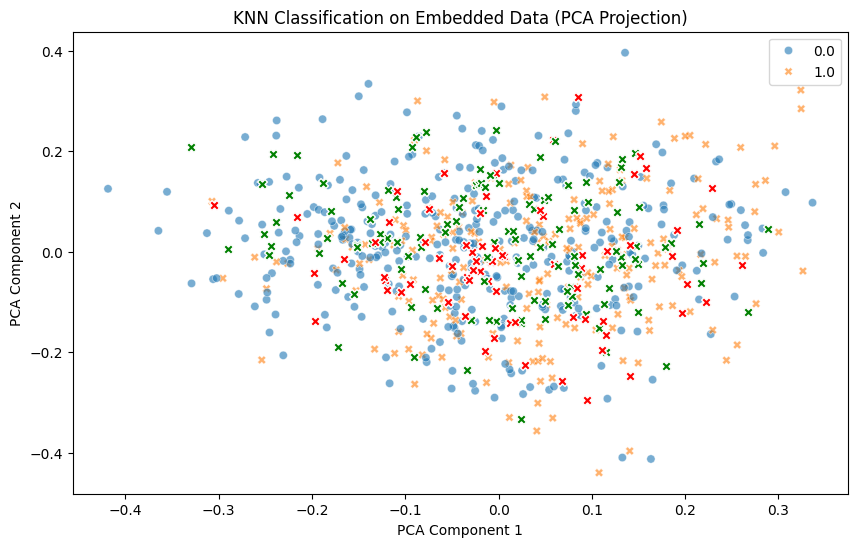

In [28]:
pca = PCA(n_components=2)
X_2d_train = pca.fit_transform(train_embeddings)

X_2d_test = pca.transform(test_embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d_train[:, 0], y=X_2d_train[:, 1], hue=y_train, style=y_train, palette="tab10", alpha=0.6)

for i, (x, y) in enumerate(X_2d_test):
    plt.scatter(x, y, color="green" if predict_cls[i] == y_test.tolist()[i] else "red", edgecolors="white", s=50, marker="X")

plt.legend()
plt.title("KNN Classification on Embedded Data (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## Log-reg

In [20]:
log_clf = LogisticRegression(random_state=111).fit(train_embeddings, y_train)

In [21]:
pred_log_clf = log_clf.predict(test_embeddings)

In [22]:
print(classification_report(y_test, pred_log_clf))

              precision    recall  f1-score   support

         0.0       0.63      0.90      0.74       103
         1.0       0.80      0.41      0.55        94

    accuracy                           0.67       197
   macro avg       0.71      0.66      0.64       197
weighted avg       0.71      0.67      0.65       197



In [23]:
print(f"MCC:{matthews_corrcoef(y_test, pred_log_clf): .2f}")

MCC: 0.37


In [24]:
save_model_path = "./baseline/logreg_baseline_ajt.pkl"
with open(save_model_path, "wb") as file:
    pickle.dump(log_clf, file)

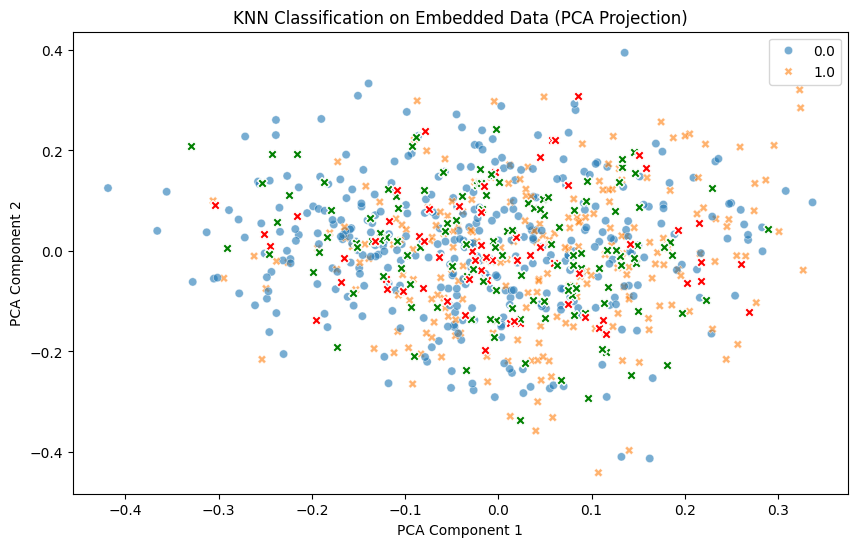

In [26]:
pca = PCA(n_components=2)
X_2d_train = pca.fit_transform(train_embeddings)

X_2d_test = pca.transform(test_embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d_train[:, 0], y=X_2d_train[:, 1], hue=y_train, style=y_train, palette="tab10", alpha=0.6)

for i, (x, y) in enumerate(X_2d_test):
    plt.scatter(x, y, color="green" if pred_log_clf[i] == y_test.tolist()[i] else "red", edgecolors="white", s=50, marker="X")

plt.legend()
plt.title("KNN Classification on Embedded Data (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Multi-class (total)

In [126]:
df.loc[X_train.index]['type_mistake'].value_counts()

type_mistake
нет ошибки        361
стилистическая     64
речевая            60
грамматическая     36
лексическая        25
пунктуационная     23
логическая         19
Name: count, dtype: int64

In [127]:
df.loc[X_test.index]['type_mistake'].value_counts()

type_mistake
нет ошибки        103
речевая            28
стилистическая     24
пунктуационная     17
грамматическая     11
лексическая         7
логическая          7
Name: count, dtype: int64

In [185]:
label_mapper = {"нет ошибки": 0, "речевая": 1, "стилистическая": 2, "пунктуационная": 3, "грамматическая": 4, "лексическая": 5, "логическая": 6}
reverse_label_mapper = {0: "нет ошибки", 1: "речевая", 2: "стилистическая", 3: "пунктуационная", 4: "грамматическая", 5: "лексическая", 6: "логическая"}

In [186]:
y_train_multi = df.loc[X_train.index]['type_mistake'].map(label_mapper)
y_test_multi = df.loc[X_test.index]['type_mistake'].map(label_mapper)

In [187]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(train_embeddings, y_train_multi)

KNeighborsClassifier(n_neighbors=2)

In [188]:
predict_cls = knn.predict(test_embeddings)

In [189]:
predict_cls

array([0, 0, 6, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 1, 0, 0, 2, 0, 1, 0, 4, 0, 0, 0, 0, 1, 2, 0, 0, 4, 0, 0,
       0, 0, 1, 4, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 5, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 2, 0, 2,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [190]:
y_test_multi

765    0
39     3
213    1
201    1
237    0
      ..
360    2
414    0
537    0
526    0
137    0
Name: type_mistake, Length: 197, dtype: int64

In [191]:
from sklearn.metrics import classification_report
print(classification_report(y_test_multi, predict_cls))

              precision    recall  f1-score   support

           0       0.57      0.89      0.70       103
           1       0.38      0.21      0.27        28
           2       0.09      0.04      0.06        24
           3       0.50      0.06      0.11        17
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         7

    accuracy                           0.51       197
   macro avg       0.22      0.17      0.16       197
weighted avg       0.41      0.51      0.42       197



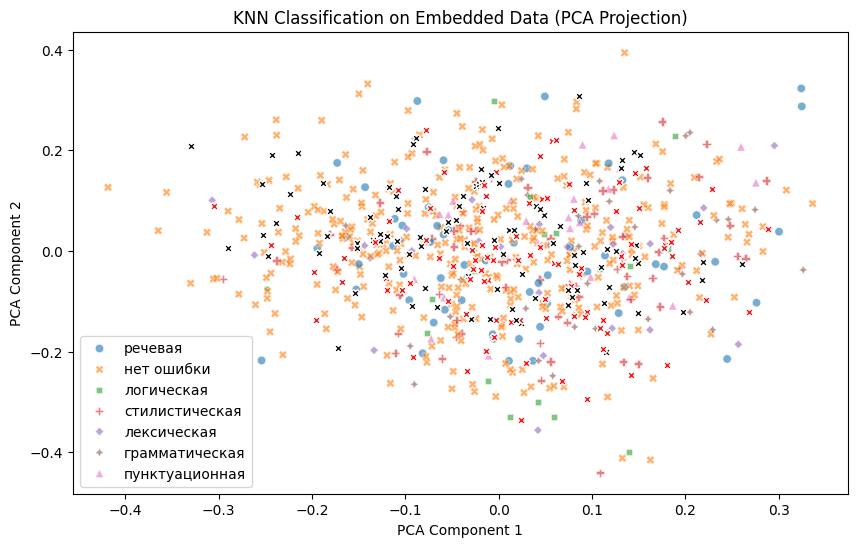

In [192]:
pca = PCA(n_components=2)
X_2d_train = pca.fit_transform(train_embeddings)

X_2d_test = pca.transform(test_embeddings)

y_train_multi_reverse = y_train_multi.map(reverse_label_mapper)
y_test_multi_reverse = y_test_multi.map(reverse_label_mapper)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d_train[:, 0], y=X_2d_train[:, 1], hue=y_train_multi_reverse, style=y_train_multi_reverse, palette="tab10", alpha=0.6)

for i, (x, y) in enumerate(X_2d_test):
    plt.scatter(x, y, color="black" if predict_cls[i] == y_test_multi.tolist()[i] else "red", edgecolors="white", s=30, marker="X")

plt.legend()
plt.title("KNN Classification on Embedded Data (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Multi-class (only mistakes)

In [161]:
only_mistakes_ids = df[df.type_mistake != 'нет ошибки'].index
idx_train_only_mistakers = set(only_mistakes_ids) & set(X_train.index)
idx_test_only_mistakers = set(only_mistakes_ids) & set(X_test.index)

In [165]:
len(idx_train_only_mistakers), len(idx_test_only_mistakers)

(227, 94)

In [170]:
train_embeddings_mistakes = get_embeddings(X_train.loc[list(idx_train_only_mistakers)].values.tolist())
test_embeddings_mistakes = get_embeddings(X_test.loc[list(idx_test_only_mistakers)].values.tolist())

In [171]:
y_train_multi_mistakes = df.loc[list(idx_train_only_mistakers)]['type_mistake'].map(label_mapper)
y_test_multi_mistakes = df.loc[list(idx_test_only_mistakers)]['type_mistake'].map(label_mapper)

In [172]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(train_embeddings_mistakes, y_train_multi_mistakes)

KNeighborsClassifier(n_neighbors=2)

In [173]:
predict_cls = knn.predict(test_embeddings_mistakes)

In [174]:
predict_cls

array([2, 4, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 3, 1, 1, 4, 1, 1, 1,
       2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 5, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2,
       1, 1, 1, 2, 4, 1, 6, 4, 3, 1, 3, 1, 2, 1, 1, 2, 1, 2, 1, 2, 4, 4,
       1, 2, 1, 3, 1, 3, 1, 4, 1, 1, 3, 2, 1, 3, 2, 4, 5, 1, 1, 2, 1, 4,
       2, 1, 2, 2, 1, 4])

In [177]:
y_test_multi_mistakes

2      1
517    4
518    4
7      4
10     3
      ..
443    3
444    3
461    4
498    1
501    5
Name: type_mistake, Length: 94, dtype: int64

In [176]:
print(classification_report(y_test_multi_mistakes, predict_cls))

              precision    recall  f1-score   support

           1       0.43      0.68      0.53        28
           2       0.30      0.38      0.33        24
           3       0.29      0.12      0.17        17
           4       0.10      0.09      0.10        11
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         7

    accuracy                           0.33        94
   macro avg       0.19      0.21      0.19        94
weighted avg       0.27      0.33      0.28        94



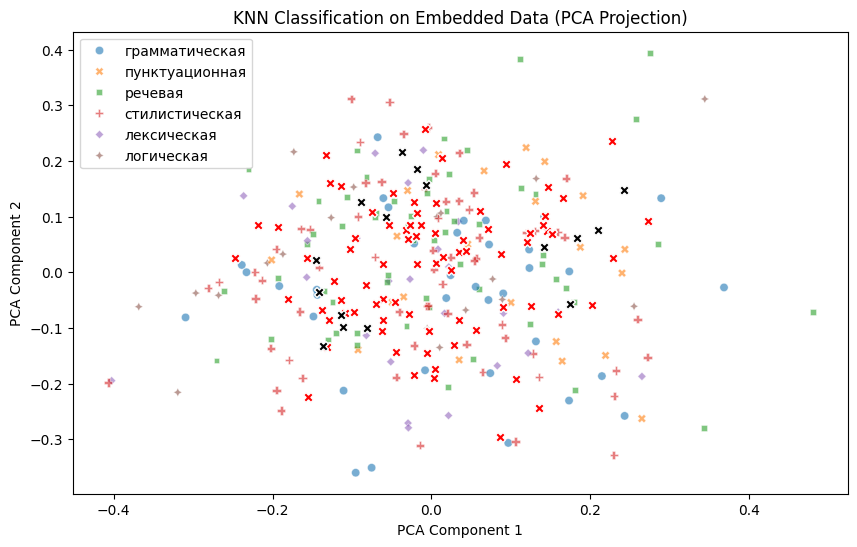

In [184]:
pca = PCA(n_components=2)
X_2d_train = pca.fit_transform(train_embeddings_mistakes)

X_2d_test = pca.transform(test_embeddings_mistakes)

y_train_multi_mistakes_reverse = y_train_multi_mistakes.map(reverse_label_mapper)
y_test_multi_mistakes_reverse = y_test_multi_mistakes.map(reverse_label_mapper)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d_train[:, 0], y=X_2d_train[:, 1], hue=y_train_multi_mistakes_reverse, style=y_train_multi_mistakes_reverse, palette="tab10", alpha=0.6)

for i, (x, y) in enumerate(X_2d_test):
    plt.scatter(x, y, color="black" if predict_cls[i] == y_test_multi.tolist()[i] else "red", edgecolors="white", s=50, marker="X")

plt.legend()
plt.title("KNN Classification on Embedded Data (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Comparison w other models

In [13]:
test_df['is_correct'] = test_df['is_mistake'].apply(lambda x: 1 if x == 0 else 0)

## ruRoBERTa-large-rucola

In [16]:
model_name = "RussianNLP/ruRoBERTa-large-rucola"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

In [17]:
tokenized_text = tokenizer(test_df.text.values.tolist(), padding='max_length', truncation=True, return_tensors='pt', max_length=128)
pred = model(input_ids=tokenized_text['input_ids'].to(device), attention_mask=tokenized_text['attention_mask'].to(device))
out_pred = pred.logits.argmax(axis=1).cpu().tolist()

In [18]:
print(classification_report(test_df['is_correct'], out_pred))
print('\n')
print(f"MCC: {matthews_corrcoef(test_df['is_correct'], out_pred):.2f}")

              precision    recall  f1-score   support

           0       0.86      0.38      0.53        94
           1       0.63      0.94      0.75       103

    accuracy                           0.68       197
   macro avg       0.74      0.66      0.64       197
weighted avg       0.74      0.68      0.65       197



MCC: 0.40


## RuModernBERT-small-rucola

In [14]:
model_name = "d0rj/RuModernBERT-small-rucola"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.to(device)

config.json:   0%|          | 0.00/2.26k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/138M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.75M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 384, padding_idx=50283)
      (norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=384, out_features=1152, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=384, out_features=384, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=384, out_features=1152, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=576, out_features=384, bias=False)
        )
      )

In [15]:
tokenized_text = tokenizer(test_df.text.values.tolist(), padding='max_length', truncation=True, return_tensors='pt', max_length=128)
pred = model(input_ids=tokenized_text['input_ids'].to(device), attention_mask=tokenized_text['attention_mask'].to(device))
out_pred = pred.logits.argmax(axis=1).cpu().tolist()

In [16]:
print(classification_report(test_df['is_correct'], out_pred))
print('\n')
print(f"MCC: {matthews_corrcoef(test_df['is_correct'], out_pred):.2f}")

              precision    recall  f1-score   support

           0       0.55      0.55      0.55        94
           1       0.59      0.58      0.59       103

    accuracy                           0.57       197
   macro avg       0.57      0.57      0.57       197
weighted avg       0.57      0.57      0.57       197



MCC: 0.14


## roberta-base-CoLA

In [52]:
model_name = "textattack/roberta-base-CoLA"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.to(device)

config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at textattack/roberta-base-CoLA were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [55]:
tokenized_text = tokenizer(test_df.text.values.tolist(), padding='max_length', truncation=True, return_tensors='pt', max_length=128)
pred = model(input_ids=tokenized_text['input_ids'].to(device), attention_mask=tokenized_text['attention_mask'].to(device))
out_pred = pred.logits.argmax(axis=1).cpu().tolist()

In [60]:
sum(out_pred)

197

In [58]:
print(classification_report(test_df['is_correct'], out_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        94
           1       0.52      1.00      0.69       103

    accuracy                           0.52       197
   macro avg       0.26      0.50      0.34       197
weighted avg       0.27      0.52      0.36       197



/home/shared/nk/dl2024/train_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shared/nk/dl2024/train_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shared/nk/dl2024/train_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i